# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [2]:
import tensorflow as tf
import os

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [19]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [15]:
# Set the directory for our dataset variables
data_dir = 'data' 

In [16]:
# Create list of image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
# Optional
# img = cv2.imread(os.path.join(data_dir, 'happy', '154006829.jpg'))
# img.shape
# plt.imshow(img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

In [23]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) # Load image into OpenCV
            tip = imghdr.what(image_path) # Checks it a valid image extension
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [24]:
import numpy as np
from matplotlib import pyplot as plt

In [25]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 171 files belonging to 2 classes.


In [39]:
# Define parameters for representing the images and use the Keras/tensorflow method "image_dataset_from_directory" to transform our images into numeric matrices.

data_dir = "C:\\Users\\caleb.adepoju\\Desktop\\UoH-AI-DS\\ImageClassification\\data"

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 171 files belonging to 2 classes.
Using 137 files for training.
Found 171 files belonging to 2 classes.
Using 34 files for validation.
['happy', 'sad']


In [50]:
data_iterator = data.as_numpy_iterator()

In [51]:
# Get another batch from the Iterator
batch = data_iterator.next()

In [52]:
# Sad People = 1
# Happy People = 2
batch[1]

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

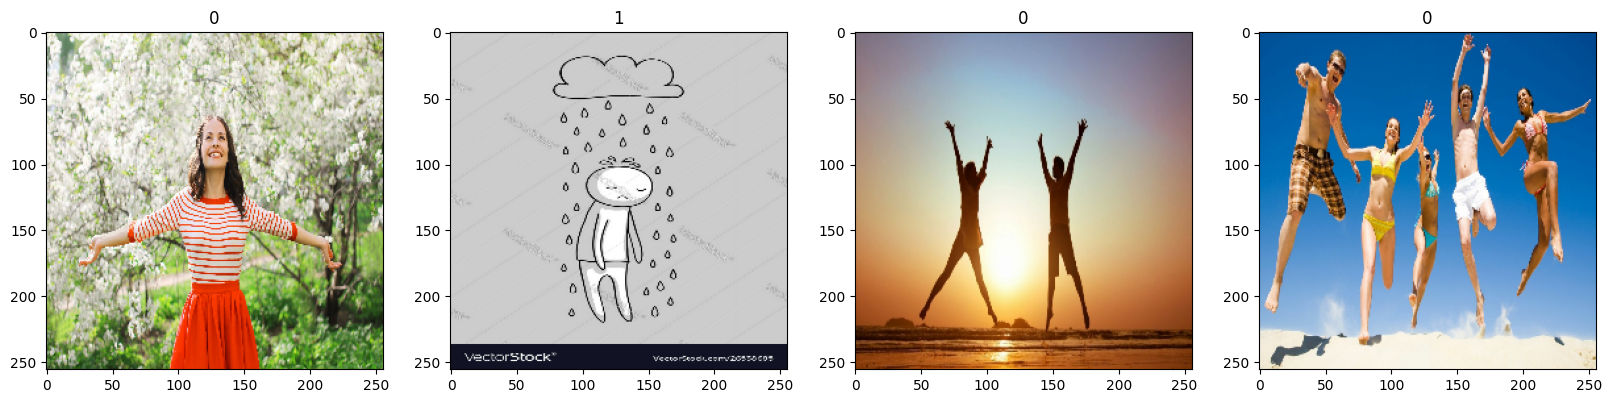

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing
# 4. Scale Data

In [54]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [58]:
scaled_itr = data.as_numpy_iterator()

In [ ]:
scaled_batch = scaled_itr.next()

In [ ]:
scaled_batch[1].max()

# 5. Split Data

In [63]:
len(data)

6

In [68]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [73]:
train_size

6

In [74]:
# Using Take and Skip method to show the size of data to be used for each stages
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [75]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [77]:
model = Sequential()

In [78]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [79]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) # Using BinaryCrossEnthropy due to our output

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [81]:
logdir='C:\\Users\\caleb.adepoju\\Desktop\\UoH-AI-DS\\ImageClassification\\logs'

In [82]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# Training the model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 31s 5s/step - loss: 1.0605 - accuracy: 0.5469 - val_loss: 0.8571 - val_accuracy: 0.2812
Epoch 2/20
4/4 [==============================] - 21s 4s/step - loss: 0.6536 - accuracy: 0.5625 - val_loss: 0.7450 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 19s 4s/step - loss: 0.6060 - accuracy: 0.5859 - val_loss: 0.5822 - val_accuracy: 0.6875
Epoch 4/20
4/4 [==============================] - 19s 4s/step - loss: 0.5488 - accuracy: 0.7031 - val_loss: 0.4607 - val_accuracy: 0.7812
Epoch 5/20
4/4 [==============================] - 20s 5s/step - loss: 0.4895 - accuracy: 0.7812 - val_loss: 0.5007 - val_accuracy: 0.8125
Epoch 6/20
4/4 [==============================] - 18s 4s/step - loss: 0.4504 - accuracy: 0.8359 - val_loss: 0.4128 - val_accuracy: 0.7812
Epoch 7/20
4/4 [==============================] - 13s 3s/step - loss: 0.3721 - accuracy: 0.8125 - val_loss: 0.5233 - val_accuracy: 0.7500
Epoch 8/20
4/4 [==================

# 8. Plot Performance

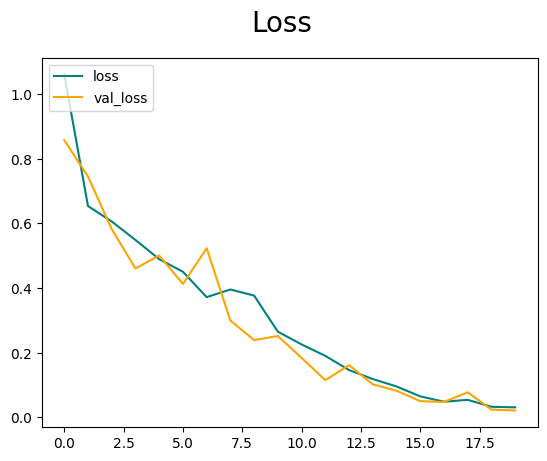

In [84]:
# If loss is decreasing and validation loss is increasing it means you have got overfitting. You will need to add more data or regularize (regularization) the train dataset
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

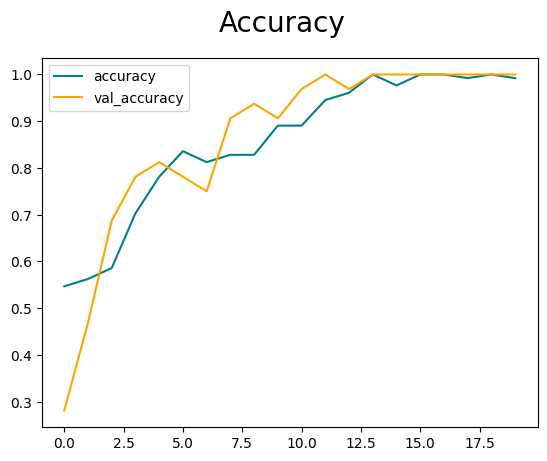

In [85]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [86]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [87]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [88]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 764ms/step


In [90]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


# 10. Test

In [91]:
import cv2

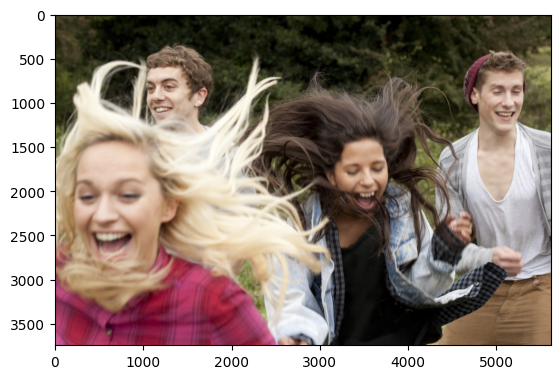

In [103]:
img = cv2.imread('htest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

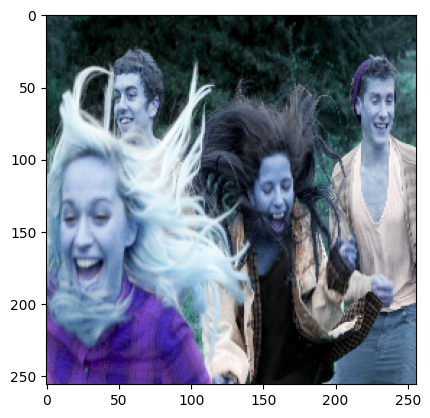

In [104]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [106]:
# Passing image to our model for prediction. However, model expect us to pass batch of images but in here we are passing a single image
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 81ms/step


In [107]:
yhat

array([[0.40340775]], dtype=float32)

In [109]:
if yhat > 0.5: 
    print('Predicted class is Sad')
else:
    print('Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)